# CIFAR10 Image Classification using Keras 简洁版

In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from time import time
from keras.utils import to_categorical
from utils import make_parallel, accuracy_curve
%matplotlib inline

nb_classes = 10
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

Using TensorFlow backend.


## Mean Subtraction Per Channel

In [44]:
def mean_subtraction(data):
    [mean_r, mean_g, mean_b] = np.mean(data, axis=(0,1,2))
    data[:, :, :, 0] -= mean_r
    data[:, :, :, 1] -= mean_g
    data[:, :, :, 2] -= mean_b
    
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
mean_subtraction(X_train)
mean_subtraction(X_test)
X_train /= 255
X_test /= 255

In [56]:
x = Input(shape=(32, 32, 3))
y = x
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Flatten()(y)
y = Dropout(0.5)(y)
y = Dense(units=nb_classes, activation='softmax', kernel_initializer='he_normal')(y)

model1 = Model(inputs=x, outputs=y, name='model1')

print(model1.summary())

model1 = make_parallel(model1, 2)

model1.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 8, 8, 128)         0         
__________

In [53]:
def train(model, batch, epoch, data_augmentation=True):
    start = time()
    es = EarlyStopping(monitor='val_acc', patience=20)
    mc = ModelCheckpoint('CIFAR10-EP{epoch:02d}-ACC{val_acc:.4f}.h5', monitor='val_acc', save_best_only=True)
    
    if data_augmentation:
        aug = ImageDataGenerator(width_shift_range = 0.125, height_shift_range = 0.125, horizontal_flip = True)
        aug.fit(X_train)
        gen = aug.flow(X_train, y_train, batch_size=batch)
        h = model.fit_generator(generator=gen, 
                                 steps_per_epoch=50000/batch, 
                                 epochs=epoch, 
                                 validation_data=(X_test, y_test),
                                 callbacks=[es, mc])
    else:
        start = time()
        h = model.fit(x=X_train, 
                      y=y_train, 
                      batch_size=batch, 
                      epochs=epoch, 
                      validation_data=(X_test, y_test),
                      callbacks=[es, mc])
    
    print('\n@ Total Time Spent: %.2f seconds' % (time() - start))
    acc, val_acc = h.history['acc'], h.history['val_acc']
    m_acc, m_val_acc = np.argmax(acc), np.argmax(val_acc)
    print("@ Best Training Accuracy: %.2f %% achieved at EP #%d." % (acc[m_acc] * 100, m_acc + 1))
    print("@ Best Testing Accuracy: %.2f %% achieved at EP #%d." % (val_acc[m_val_acc] * 100, m_val_acc + 1))
    return h

Epoch 1/200
782/781 [==============================] - 18s - loss: 1.6257 - acc: 0.4098 - val_loss: 1.2768 - val_acc: 0.5376
Epoch 2/200
782/781 [==============================] - 17s - loss: 1.1663 - acc: 0.5827 - val_loss: 0.9300 - val_acc: 0.6690
Epoch 3/200
782/781 [==============================] - 17s - loss: 0.9495 - acc: 0.6689 - val_loss: 1.0057 - val_acc: 0.6508
Epoch 4/200
782/781 [==============================] - 17s - loss: 0.8167 - acc: 0.7130 - val_loss: 1.0234 - val_acc: 0.6664
Epoch 5/200
782/781 [==============================] - 18s - loss: 0.7225 - acc: 0.7487 - val_loss: 0.7062 - val_acc: 0.7565
Epoch 6/200
782/781 [==============================] - 18s - loss: 0.6564 - acc: 0.7696 - val_loss: 0.7135 - val_acc: 0.7510
Epoch 7/200
782/781 [==============================] - 17s - loss: 0.5982 - acc: 0.7935 - val_loss: 0.5643 - val_acc: 0.8023
Epoch 8/200
782/781 [==============================] - 17s - loss: 0.5578 - acc: 0.8070 - val_loss: 0.6275 - val_acc: 0.7844


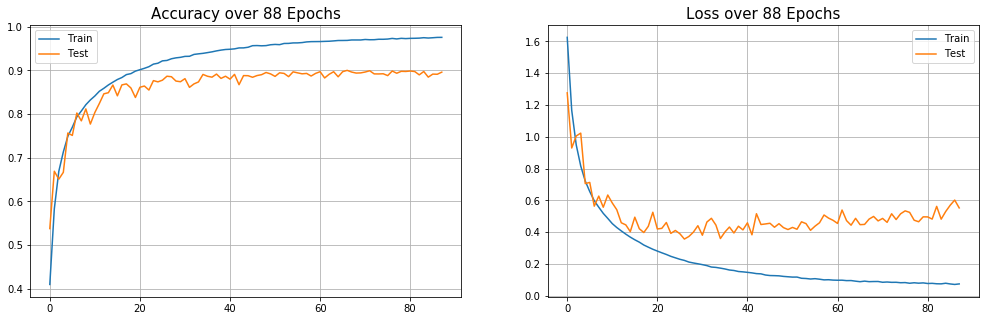

In [57]:
epoch = 200
batch = 64

h = train(model1, batch, epoch)
accuracy_curve(h)

Epoch 1/200
391/390 [==============================] - 16s - loss: 0.0603 - acc: 0.9797 - val_loss: 0.5084 - val_acc: 0.8950
Epoch 2/200
391/390 [==============================] - 11s - loss: 0.0567 - acc: 0.9808 - val_loss: 0.5572 - val_acc: 0.8931
Epoch 3/200
391/390 [==============================] - 11s - loss: 0.0620 - acc: 0.9796 - val_loss: 0.5973 - val_acc: 0.8974
Epoch 4/200
391/390 [==============================] - 11s - loss: 0.0579 - acc: 0.9807 - val_loss: 0.4917 - val_acc: 0.8970
Epoch 5/200
391/390 [==============================] - 11s - loss: 0.0540 - acc: 0.9813 - val_loss: 0.6540 - val_acc: 0.8918
Epoch 6/200
391/390 [==============================] - 11s - loss: 0.0562 - acc: 0.9818 - val_loss: 0.5776 - val_acc: 0.8975
Epoch 7/200
391/390 [==============================] - 11s - loss: 0.0537 - acc: 0.9818 - val_loss: 0.5130 - val_acc: 0.8959
Epoch 8/200
391/390 [==============================] - 11s - loss: 0.0528 - acc: 0.9817 - val_loss: 0.5563 - val_acc: 0.8980


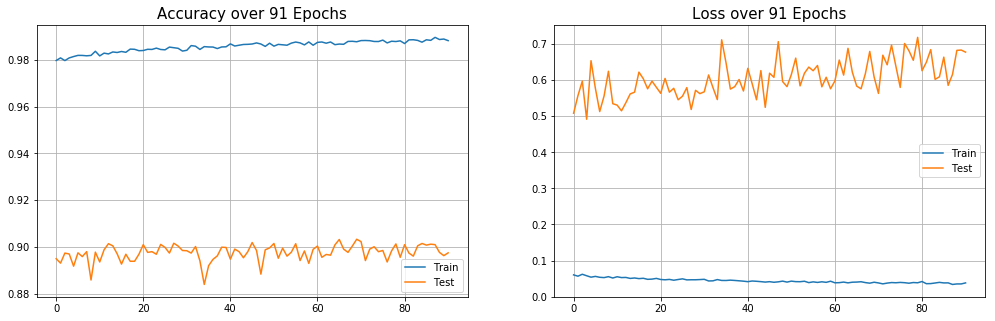

In [58]:
epoch = 200
batch = 128

h = further_train(model1, batch, epoch)
accuracy_curve(h)